# Plot and correlate spatial trends in radiation and temperature

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CERES-EBAF data

In [2]:
ceres_dir = '/glade/work/jonahshaw/obs/CERES'
ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [3]:
ceres_ds = xr.open_dataset('%s/%s' % (ceres_dir,ceres_file))

ceres_ds = ceres_ds.assign_coords(lon=(ceres_ds.lon % 360)).sortby('lon')

#### Add an absorbed solar radiation variable

In [4]:
ceres_ds['ASR'] = ceres_ds['solar_mon'] - ceres_ds['toa_sw_all_mon']

#### Add an albedo variable

In [5]:
temp_alb = (ceres_ds['toa_sw_all_mon'] / ceres_ds['solar_mon'])
# weird 2-step process required??
ceres_ds['albedo'] = temp_alb.where(ceres_ds['solar_mon'] > 15) #.where(temp_alb > 15,np.nan) # poorly defined when insolation is less than 15 W/m^2

## Load GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [6]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [7]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [8]:
giss_tsel = giss1.sel(time=slice('2000-03','2021-03'))

### Function to calculate spatial trends for each month

Return a (lat,lon,month) dataarray with the trend for each gridcell

In [23]:
# If I figure out apply_ufunc I could get rid of the loop over months...
def spatial_trends_monthly(ds):
    '''
    Returns a (lat,lon,month) dataarray with the linear trend slope for each gridcell.
    Makes use of the xarray.polyfit vectorized function.
    '''
    
    # keep shape and dims for output
    empty = ds.groupby('time.month').mean('time').copy()
    
    month_groups = ds.groupby('time.month')
    
    for i,grp in month_groups:
        _monthmonths = grp.groupby('time.year').mean(dim='time')
        
        try:
            _spat_trend = _monthmonths.polyfit(dim='year',deg=1)['polyfit_coefficients'].sel(degree=1)
        except: # set output as nans if the call fails
            print('polyfit failed for month #%d' % i)
            blank_shape = empty[i-1,:,:].shape
            _spat_trend = np.nan * np.zeros(blank_shape)
#             print(_monthmonths.shape)
#             return _monthmonths
        empty[i-1,:,:] = _spat_trend

    empty.name = empty.name + '_trend'
    return empty

#### Calculate and plot spatial OLR trends

In [10]:
olr_trends = spatial_trends_monthly(ceres_ds['toa_lw_all_mon'])

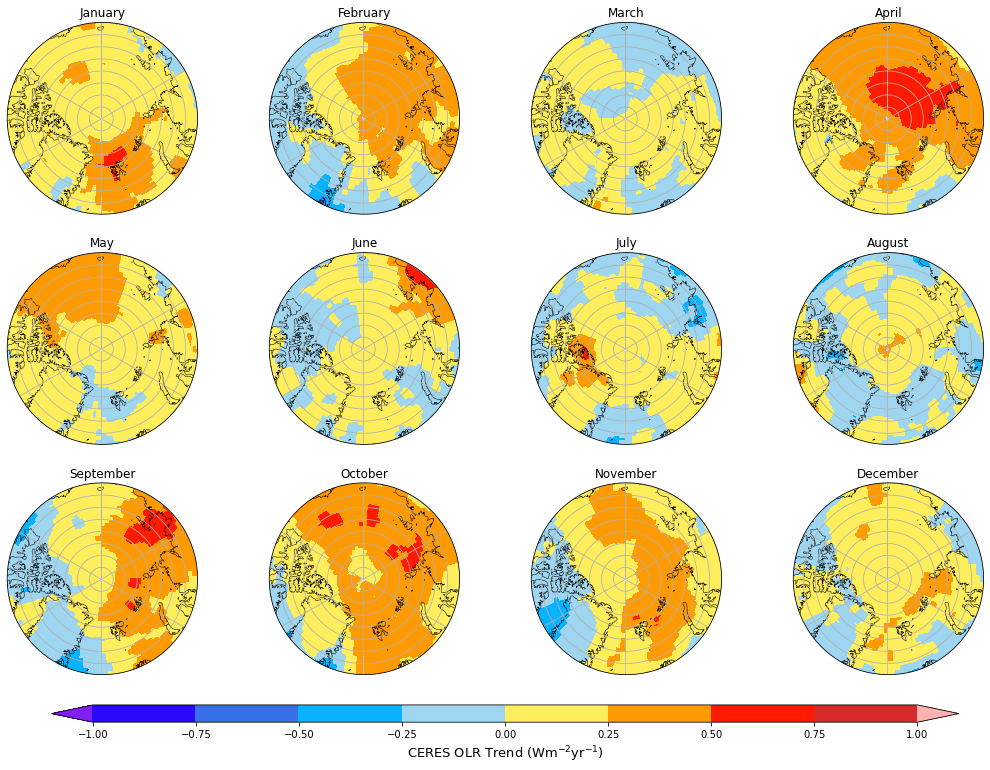

In [51]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

for i,(ax,month) in enumerate(zip(axs.flat,olr_trends)):
    polarCentral_set_latlim([70,90], ax)
#     print(month.shape)
#     break
#     im = out.where(out.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),cmap=cmaps.ncl_default,levels=np.linspace(-1,1,9),extend='both')
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=12)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)

#### Do Clearsky OLR trends

In [80]:
olrclr_trends = spatial_trends_monthly(ceres_ds['toa_lw_clr_c_mon'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


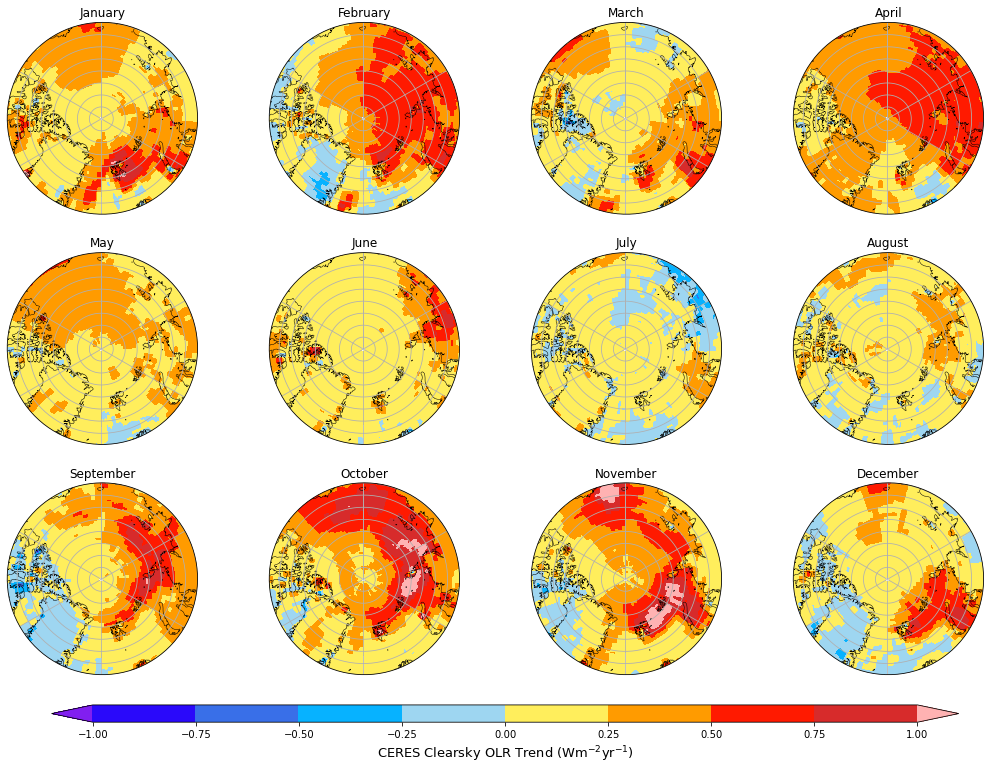

In [81]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

for i,(ax,month) in enumerate(zip(axs.flat,olrclr_trends)):
    polarCentral_set_latlim([70,90], ax)
#     print(month.shape)
#     break
#     im = out.where(out.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),cmap=cmaps.ncl_default,levels=np.linspace(-1,1,9),extend='both')
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=12)
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("CERES Clearsky OLR Trend (Wm$^{-2}$yr$^{-1}$)",fontsize=13)

## The GISS spatial trends are giving me errors

### I probably need to clean the data from some reason.

In [24]:
temp_trends = spatial_trends_monthly(giss_tsel['air'])

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


polyfit failed for month #8
polyfit failed for month #9


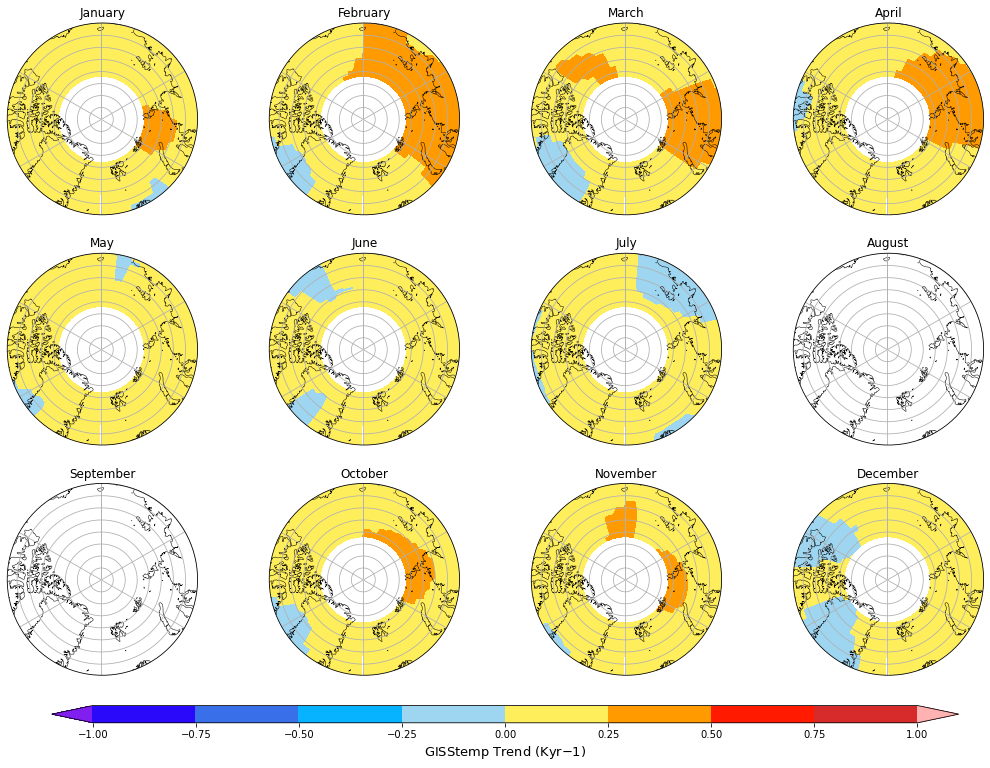

In [79]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy
import cartopy.feature as cfeature

mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axs = sp_map(nrows=3, ncols=4, projection=ccrs.NorthPolarStereo(), figsize=[18,12])

for i,(ax,month) in enumerate(zip(axs.flat,temp_trends)):
    polarCentral_set_latlim([70,90], ax)
#     print(month.shape)
#     break
#     im = out.where(out.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
    
    # The GISS data appears to be prescribed above ~83N
    month = month.where(month.lat < 83)
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),cmap=cmaps.ncl_default,levels=np.linspace(-1,1,9),extend='both')
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=12)
#     ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

#     ax.add_feature(cfeature.COASTLINE, linewidth=0.5);
#     ax.add_feature(cfeature.BORDERS, linewidth=0.5);
#     gl = ax.gridlines(draw_labels=True,dms=True)
    
#     gl.xlocator = mticker.FixedLocator(np.arange(-180,180,60))
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0}

#     gl.yformatter = LATITUDE_FORMATTER
#     gl.ylocator = mticker.FixedLocator(np.arange(70,86,5),200)
#     gl.label_artists
    
#     break
    
cbar_axh = fig.add_axes([0.17, 0.07, 0.70, 0.02])
cbar1 = fig.colorbar(im, cax=cbar_axh,orientation='horizontal')

cbar1.set_label("GISStemp Trend (Kyr${-1}$)",fontsize=13)

# ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

# gl = ax.gridlines(draw_labels=True)

# gl.xlocator = mticker.FixedLocator(np.concatenate([np.arange(-180,-89,30),np.arange(90,181,30)]))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.xlabel_style = {'size': 12, 'color': 'k','rotation':0}

# gl.yformatter = LATITUDE_FORMATTER
# gl.ylocator = mticker.FixedLocator(np.arange(70,86,5),200)

In [83]:
august = giss_tsel['air'].sel(time=(giss_tsel['air']['time.month']==8))

In [88]:
august.polyfit(dim='time',deg=1)

ValueError: setting an array element with a sequence.

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


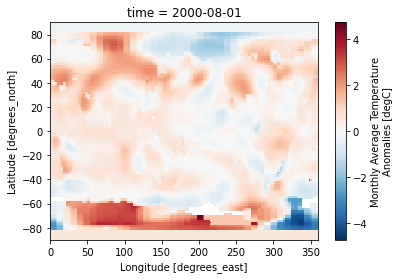

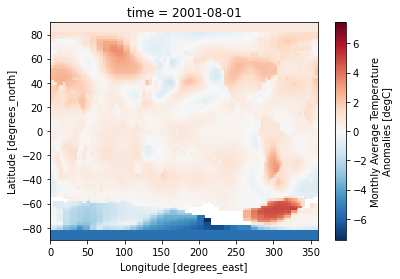

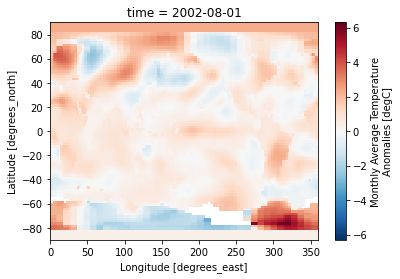

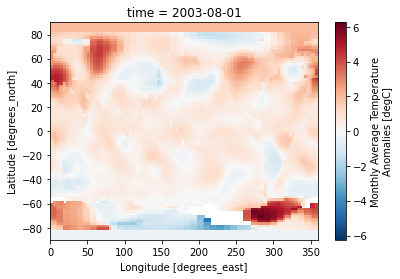

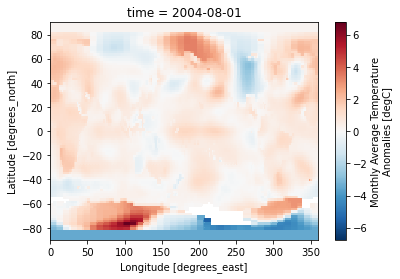

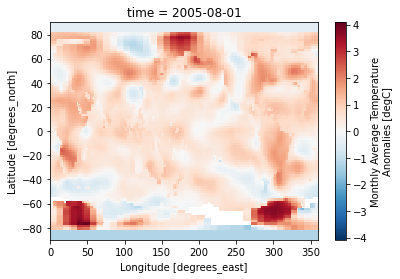

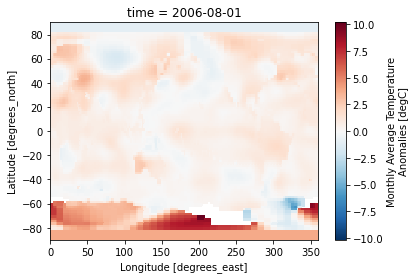

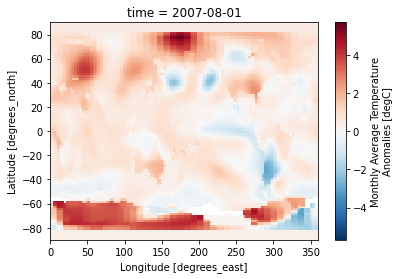

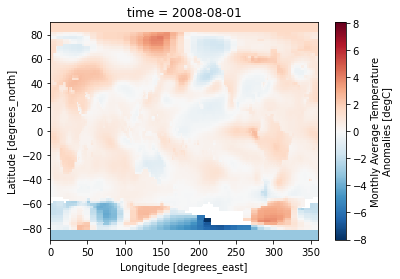

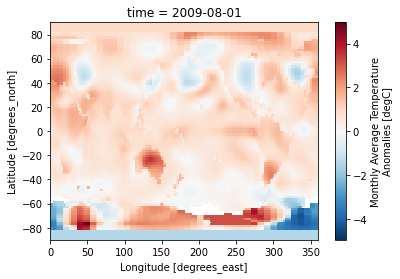

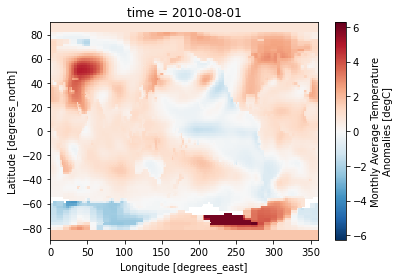

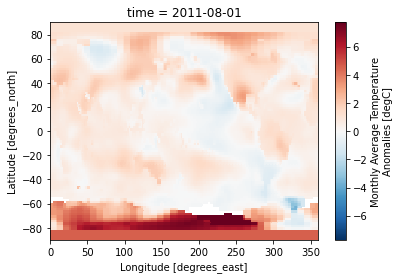

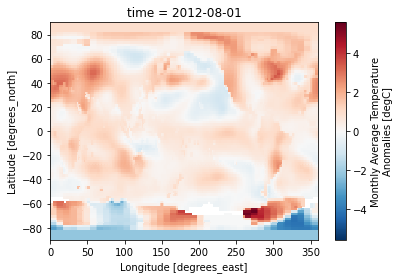

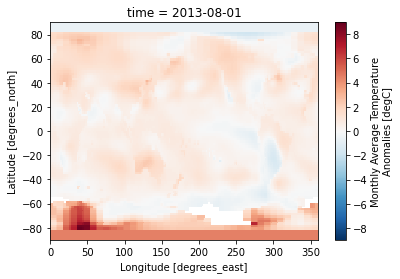

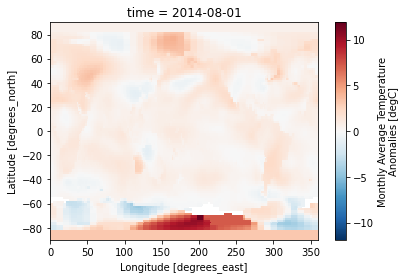

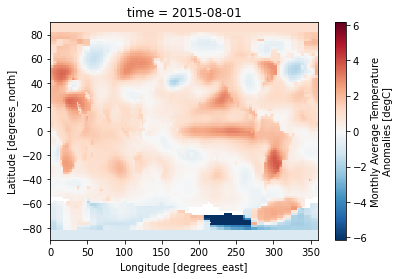

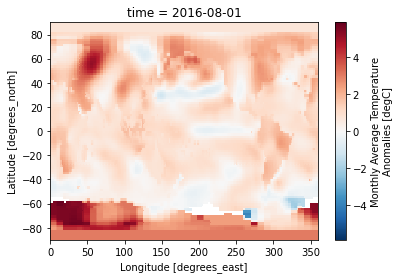

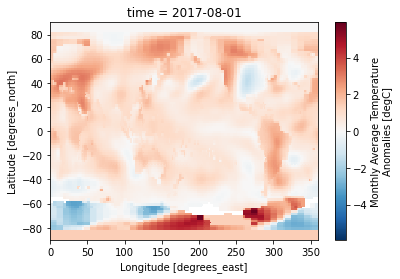

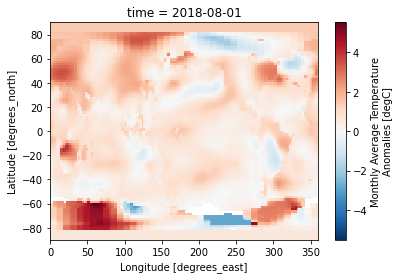

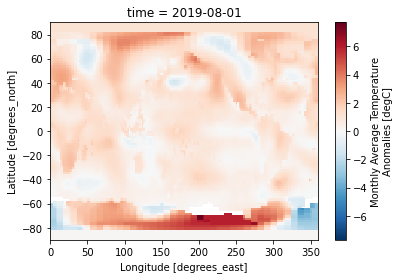

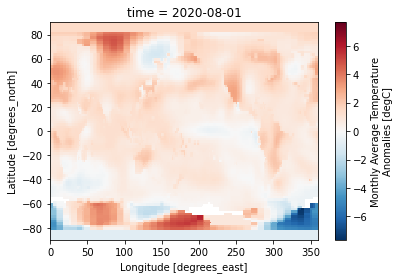

In [85]:
for i in august:
    plt.figure()
    i.plot()

In [69]:
temp_trends.polyfit(dim='year',deg=1)

ValueError: setting an array element with a sequence.

In [ ]:
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

fig,axs = sp_map(nrows=4, ncols=3, projection=ccrs.NorthPolarStereo(), figsize=[15,15])

for i,(ax,month) in enumerate(zip(axs.flat,temp_trends)):
    polarCentral_set_latlim([70,90], ax)
#     print(month.shape)
#     break
#     im = out.where(out.lat>70).plot(ax=ax, transform=ccrs.PlateCarree())
    
    im = ax.contourf(month['lon'],month['lat'],month,transform=ccrs.PlateCarree(),cmap=cmaps.ncl_default,levels=np.linspace(-1,1,9),extend='both')
    
    add_map_features(ax)
    
    label = mon_dict[str(i+1)]
    
    ax.set_title(label,fontsize=12)
    
fig.colorbar(im)

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180, time: 251)
Coordinates:
  * lat      (lat) float32 89.0 87.0 85.0 83.0 81.0 ... -83.0 -85.0 -87.0 -89.0
  * lon      (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * time     (time) datetime64[ns] 2000-03-01 2000-04-01 ... 2021-01-01
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    title:          GISS Surface Temperature Analysis (GISTEMP): 1200km smoot...
    comments:       This is the 1200km smoothed combined land,ocean version o...
    platform:       Analysis
    Source:         http://data.giss.nasa.gov/gistemp/ source and http://data...
    Documentation:  http://www.esrl.noaa.gov/psd/data/gridded/data.gistemp.html
    references:     http://www.esrl.noaa.gov/psd/data/gridded/data.gistemp.html
    Conventions:    COARDS
    history:        created at PSD Jun 2009 by CAS. Converted to chunked, def...
    dataset_title:  GISS Surface Temperature Analysis
    References:     
    update_date:    03/2021
    data_modified:  2021-03-05